In [2]:
import torch
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import


In [4]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 890kB 13.9MB/s 
     |████████████████████████████████| 1.1MB 15.1MB/s 
     |████████████████████████████████| 3.8MB 27.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b24cc0d040d559a89730f6bc42a4329a0d313af67a6ea4486b572ed6c92ef40f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [171]:
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
import torch

import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

import pandas as pd
import numpy as np
import scipy
import math

import random
import os

In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Parse data


In [21]:
def Parse_data(file_path: str):
  """
  Parses csv file with extra commas, starts from right side of line,
  and goes to the left with column appending untill meets first column name
  :param file_path: path to csv text
  :returns: dataframe with 2 coloumns
  """
  with open(file_path) as f:
    df_dict = {name: list() for name in f.readline().strip().split(',')}
    keys = list(df_dict.keys())

    for line in f:
      separated_text = line.strip().split(',')
      for i in range(-1, -len(keys)-1, -1):
        if i != -len(keys):
          df_dict[keys[i]].append(separated_text[i])
          separated_text.pop()
        else:
          df_dict[keys[i]].append(' '.join(separated_text))

  train_df = pd.DataFrame.from_dict(df_dict)
  return train_df


train_df = Parse_data('/content/drive/My Drive/train.csv')

In [22]:
train_df.head(10), train_df.shape

(                                                text label
 0                                         ENT магнит     0
 1  Сообщение от подписчиков Поступило сообщение о...    -1
 2  Курт Воннегут « Колыбель для кошки » Продолжаю...     1
 3  Надо поугарать взять пакет из магнита и закупи...     0
 4  👌🏻☝🏻👏🏻👏🏻👏🏻 ширли-мырли-5.gif Кто все эти люди ...     0
 5  Овер сладкая хуйня пить невозможно в первый ра...    -1
 6                            Сегодняшний поход в ENT     0
 7  С праздником дорогие дамы хочу вырозить огромн...     1
 8  В рамках реализации федерального партийного пр...    -1
 9  Петроглиф автоматизация бизнеса О последствиях...     1, (23253, 2))

# Delete all non-cyrillic text

In [23]:
pattern = re.compile(r"[А-Яа-яё]+-[А-Яа-яё]+|[А-Яа-яё]+|ENT|[,.]")

splited_text = [re.findall(pattern, text) for text in train_df['text']]

In [24]:
filtred_df = pd.DataFrame({'text' : [' '.join(splited_text[i]) for i in range(len(splited_text))],
                           'label': train_df.label})

In [25]:
filtred_df.head(), filtred_df.shape

(                                                text label
 0                                         ENT магнит     0
 1  Сообщение от подписчиков Поступило сообщение о...    -1
 2  Курт Воннегут Колыбель для кошки Продолжаю мой...     1
 3  Надо поугарать взять пакет из магнита и закупи...     0
 4  ширли-мырли . Кто все эти люди которые пишут с...     0, (23253, 2))

# Calculate review length

In [26]:
lens_list = [len(text) for text in splited_text]
lens_list = sorted(lens_list)[:-100]

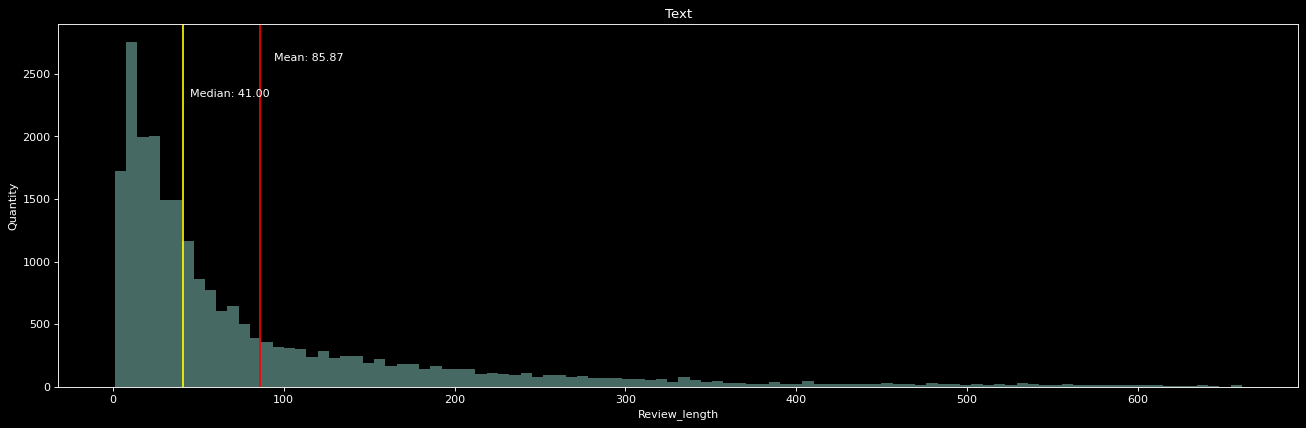

In [27]:
plt.style.use('dark_background')

figure(num=None, figsize=(20, 6), dpi=80, edgecolor='k')

plt.axvline(x=np.mean(lens_list), color='red', linestyle='-')
plt.axvline(x=np.median(lens_list), color='yellow', linestyle='-')
plt.hist(lens_list , bins=100, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.xticks(np.arange(min(lens_list)-1, max(lens_list), 100.0))
plt.title("Text")
plt.ylabel('Quantity')
plt.xlabel('Review_length')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(lens_list)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(lens_list)));
plt.text(np.median(lens_list)*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(np.median(lens_list)));

# ENT position

In [28]:
def find_tgt_token_pos(tokenized_texts: list, 
                       target_token: str):
  """
  Finding target token entry position in tokenized texts
  :param tokenized_texts: list with tokenized texts
  :param target_token: target token str
  :returns: list with int positions
  """
  target_token_position = list()
  length = len(tokenized_texts)
  for i in range(length):
    if target_token in tokenized_texts[i]:
      target_token_position.append(np.where(np.array(tokenized_texts[i]) == target_token)[0][0])
  return target_token_position

ENT_position = find_tgt_token_pos(splited_text, target_token='ENT')
ENT_position = sorted(ENT_position)[:-100]

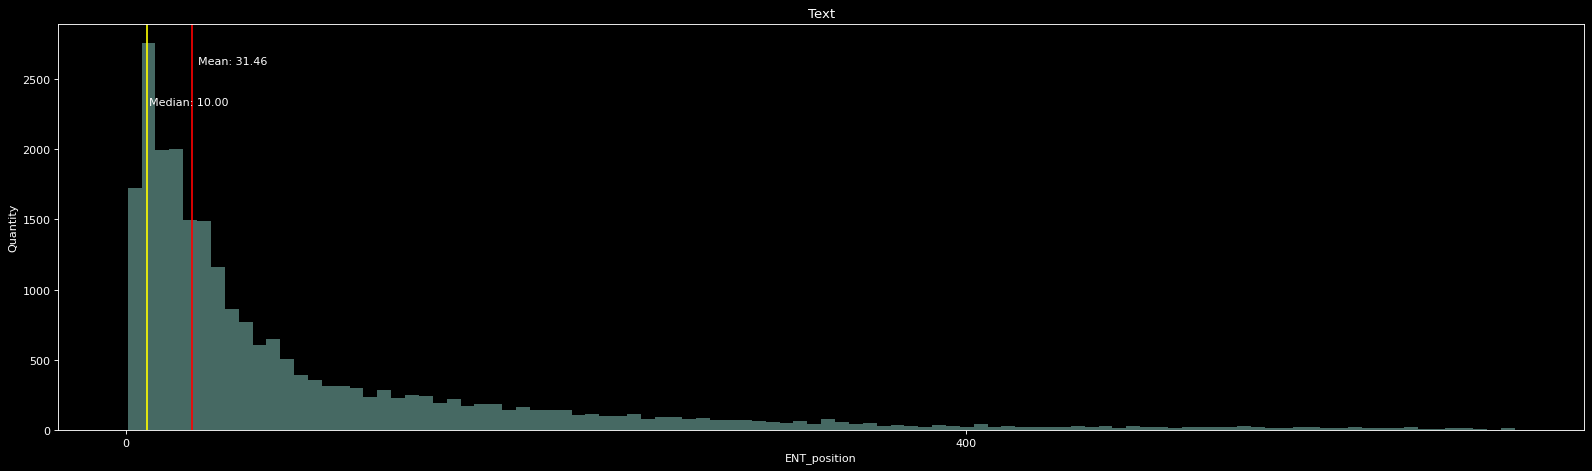

In [29]:
plt.style.use('dark_background')

figure(num=None, figsize=(20, 6), dpi=80, edgecolor='k')

plt.axvline(x=np.mean(ENT_position), color='red', linestyle='-')
plt.axvline(x=np.median(ENT_position), color='yellow', linestyle='-')
plt.hist(lens_list , bins=100, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.xticks(np.arange(min(ENT_position), max(ENT_position), 400.0))
plt.title("Text")
plt.ylabel('Quantity')
plt.xlabel('ENT_position')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(ENT_position)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(ENT_position)));
plt.text(np.median(ENT_position)*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(np.median(ENT_position)));
plt.tight_layout();

# Prepare chuncks for BERT

In [30]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def tokenize_text(texts_array: list, 
                  target_token: str):
  """
  Tokenizes raw texts
  :param text_array: raw text array
  :param target_token: target token str
  :returns: list of lists with tokens
  """
  tokenized_text = list()
  for text in texts_array:
    tokenized = tokenizer.tokenize(text)
    if target_token in tokenized:
      tokenized_text.append(tokenized)
  return tokenized_text

def PAD_text(text_for_pad: list, 
             pad_length: int, 
             pad_token: str, 
             bos_token: str, 
             eos_token: str):
  """
  Pad and add special tokens to sequence
  :param text_for_pad: list with tokens
  :param pad_length: int padding length
  :param pad_token: pad token str
  :param bos_token: begin of sequence token str
  :param eos_token: end of sequence token str
  :returns: list with tokens
  """
  return [bos_token] + text_for_pad + [pad_token for i in range(pad_length)] + [eos_token]

def normalize_text_chunck(tokenized_texts: list, 
                          target_tok_pos: list, 
                          chunck_length: int, 
                          pad_token: str, 
                          bos_token: str, 
                          eos_token: str):
  """
  Creates array with text chuncks for feeding to BERT
  :param tokenized_texts: list of lists with tokens
  :param target_token: target token str
  :param chunck_length: int chunck length
  :param pad_token: pad token str
  :param bos_token: begin of sequence token str
  :param eos_token: end of sequence token str
  :returns: list with chuncks
  """
  normalized_chuncks = list()
  chunck_center = math.ceil(chunck_length/2)
  for i, text in enumerate(tokenized_text):
    chunck_start = max(0, target_tok_pos[i]-chunck_center+1)
    chunck_end = min(len(text), target_tok_pos[i]+chunck_center-2)
    text_for_PAD = text[chunck_start: chunck_end]
    pad_length = chunck_length - len(text_for_PAD) - 2
    normalized_chuncks.append(PAD_text(text_for_PAD, pad_length, pad_token, bos_token, eos_token))
  return normalized_chuncks

In [31]:
#tokenize text for chuncks
tokenized_text = tokenize_text(filtred_df.text, 
                               target_token='ent')
#find target entity position for chuncks
ENT_position = find_tgt_token_pos(tokenized_text, 
                                  target_token='ent')
#create chuncks
normalized_text_chuncks = normalize_text_chunck(tokenized_text, 
                                                ENT_position, 
                                                chunck_length=83, 
                                                pad_token='[PAD]', 
                                                bos_token='[CLS]', 
                                                eos_token='[SEP]')

# Check our chuncks

In [32]:
def check_chuncks(chuncks: list, 
                  chunck_length: int, 
                  tgt_token: str, 
                  pad_token: str, 
                  bos_token: str, 
                  eos_token: str):
  """
  Chceking chuncks for some canditions 
  :param chuncks: list of lists with tokens
  :param chunck_length: int chunck length
  :param tgt_token: target token
  :param pad_token: pad token str
  :param bos_token: begin of sequence token str
  :param eos_token: end of sequence token str
  :returns: bool
  """
  bos_flag = all([txt[0] == bos_token for txt in chuncks])
  eos_flag = all([txt[-1] == eos_token for txt in chuncks])
  tgt_flag = all([tgt_token in txt for txt in chuncks])
  lengths_flag = all([len(text) == chunck_length for text in chuncks])
  count_padded = sum([pad_token in txt for txt in chuncks])
  print(f"""\tAll chuncks start with {bos_token}: {bos_flag} |\n 
        All chuncks end with {eos_token}: {eos_flag} |\n
        All chuncks contain target token {tgt_token}: {eos_flag} |\n
        All chuncks have the same length: {lengths_flag} |\n 
        Chunks padded: {count_padded} |""")

check_chuncks(normalized_text_chuncks, 
              chunck_length=83,
              tgt_token='ent',
              pad_token='[PAD]', 
              bos_token='[CLS]', 
              eos_token='[SEP]')

	All chuncks start with [CLS]: True |
 
        All chuncks end with [SEP]: True |

        All chuncks contain target token ent: True |

        All chuncks have the same length: True |
 
        Chunks padded: 19451 |


# Modeling

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=3).to(device)

# Extract Vectors

In [34]:
MODEL_NAME = '/content/drive/My Drive/BERT_multi_sent3_analyze.pt'
model.load_state_dict(torch.load(MODEL_NAME)) #, map_location='cpu'

<All keys matched successfully>

In [35]:
def make_mask(seq: torch.tensor, 
              seq_pad_idx: int, 
              device: torch.device):
  """
  Creates mask using for BERTmodel
  :param seq: torch tensor
  :param seq_pad_idx: pad token id
  :param device: cuda or cpu torch device
  :returns: torch tensor mask with bool type
  """
  #shape[batch size, seq len]
  mask = (seq != seq_pad_idx).to(device)
  return mask

In [36]:
from IPython.display import clear_output

def extract_vectors(model: model, 
                    text_chuncks: list, 
                    pad_idx: int, 
                    device: torch.device):
  """
  Extract vectorized text chunck representation by feeding them to pretrained model
  :model: pytorch NLP model
  :param text_chuncks: list of lists with token indexes
  :param pad_idx: pad token id
  :param device: cuda or cpu torch device
  :returns: numpy array with vectors
  """
  vector_length = model.classifier.out_features
  vectors_array = np.array([[int() for i in range(vector_length)]])

  for number, chunck in enumerate(text_chuncks):
    txt_ids = torch.tensor(tokenizer.encode(chunck, add_special_tokens=False)).unsqueeze(0).to(device)
    mask = make_mask(txt_ids, pad_idx, device)
    
    outputs = model(input_ids=txt_ids, 
                    attention_mask=mask)
    
    vectors_array = np.vstack((vectors_array, outputs[0].detach().cpu().numpy()))

    print(f'chuncks vectorized: {number+1}')
    clear_output(wait=True)

  vectors_array = np.delete(vectors_array, 0, axis=0)
  return vectors_array

In [37]:
seq_pad_idx = tokenizer.pad_token_id
vectors = extract_vectors(model, 
                          normalized_text_chuncks, 
                          seq_pad_idx, 
                          device)

chuncks vectorized: 23252


# Dimensionality reduction

In [38]:
def get_labels(text_array: list, 
               text_labels: list, 
               target_token: str):
  """
  Delete all labels position where is no target token in text
  :param text_array: raw text array
  :param text_labels: text labels array
  :param target_token: target token str
  :returns: list with int labels
  """
  labels_list = list()
  for i, text in enumerate(text_array):
    if target_token in text:
      labels_list.append(text_labels[i])
  return(np.array(labels_list).astype(int))

#create array with labels for clastering
target = get_labels(filtred_df.text, 
                    filtred_df.label, 
                    target_token='ENT')

## TSNE

In [39]:
tsne = TSNE(n_components=2, init='pca', random_state=1234)

proj_TSNE = tsne.fit_transform(vectors)

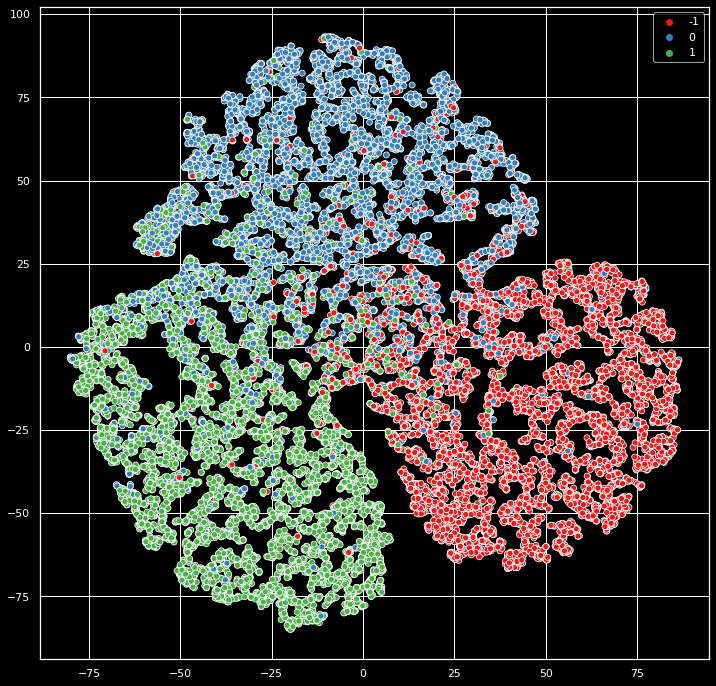

In [44]:
plt.style.use('dark_background')
ax = sns.scatterplot(x=proj_TSNE[:, 0], 
                     y=proj_TSNE[:, 1], 
                     hue=target, 
                     palette="Set1")
sns.set(rc={'figure.figsize':(12, 12)})

## PCA

In [41]:
pca = PCA(n_components=2, random_state=1234)

proj_PCA = pca.fit_transform(vectors)

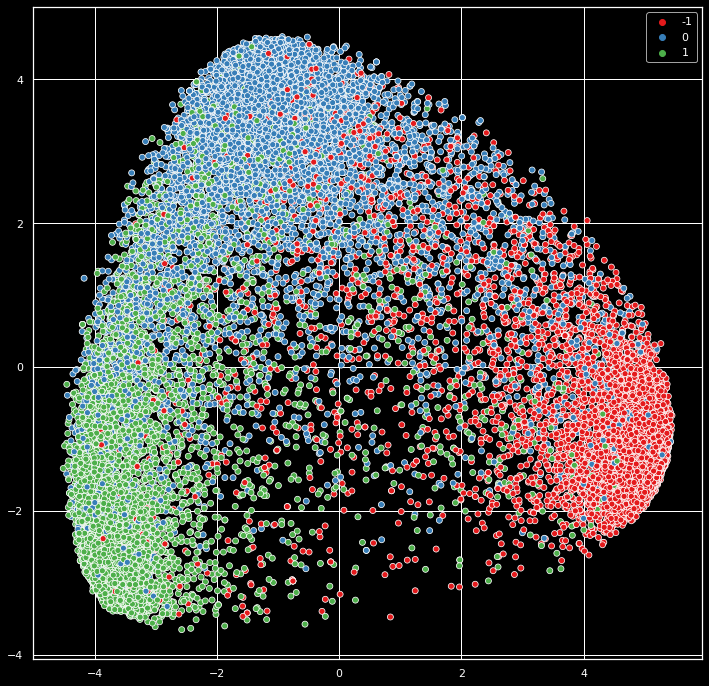

In [46]:
plt.style.use('dark_background')
ax = sns.scatterplot(x=proj_PCA[:, 0], 
                     y=proj_PCA[:, 1], 
                     hue=target, 
                     palette="Set1")
sns.set(rc={'figure.figsize':(12, 12)})

# Clustering

## DBSCAN with PCA

In [47]:
db_eps_1 = DBSCAN(eps=0.05, min_samples=10).fit(proj_PCA)
db_eps_2 = DBSCAN(eps=0.1, min_samples=10).fit(proj_PCA)
db_eps_3 = DBSCAN(eps=0.15, min_samples=10).fit(proj_PCA)
db_eps_4 = DBSCAN(eps=0.2, min_samples=10).fit(proj_PCA)
db_eps_5 = DBSCAN(eps=0.25, min_samples=10).fit(proj_PCA)
db_eps_6 = DBSCAN(eps=0.3, min_samples=10).fit(proj_PCA)

In [48]:
def creat_DBSCAN_metrics_df(models_list: list, 
                            target: list):
  """
  Creates DBSCAN dataframe with main clusters metrics
  :param models_list: list with models
  :param target: list with target labels
  :returns: pandas dataframe
  """

  metric_dict = {'Homogeneity': list(),
                'Completeness': list(),
                'V-measure': list(),
                'Adjusted Rand Index': list(),
                'Adjusted Mutual Information': list(),
                'Silhouette Coefficient': list()}

  clusters_dict = {'N_clusters': list(),
                   'n_noise': list()}

  for i, model in enumerate(models_list):
    labels = model.labels_
    clusters_dict['N_clusters'].append(len(set(labels)) - (1 if -1 in labels else 0))
    clusters_dict['n_noise'].append(list(labels).count(-1))
    metric_dict['Homogeneity'].append(metrics.homogeneity_score(target, labels))
    metric_dict['Completeness'].append(metrics.completeness_score(target, labels))
    metric_dict['V-measure'].append(metrics.v_measure_score(target, labels))
    metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(target, labels))
    metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(target, labels))
    metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

  stats_df = pd.DataFrame(metric_dict, index=['N_clusters='+str(clusters_dict['N_clusters'][i]) for i in range(0, 6)])
  return stats_df 

DBSCAN_stats_df = creat_DBSCAN_metrics_df([db_eps_1, 
                                           db_eps_2, 
                                           db_eps_3, 
                                           db_eps_4, 
                                           db_eps_5, 
                                           db_eps_6],
                                          target)

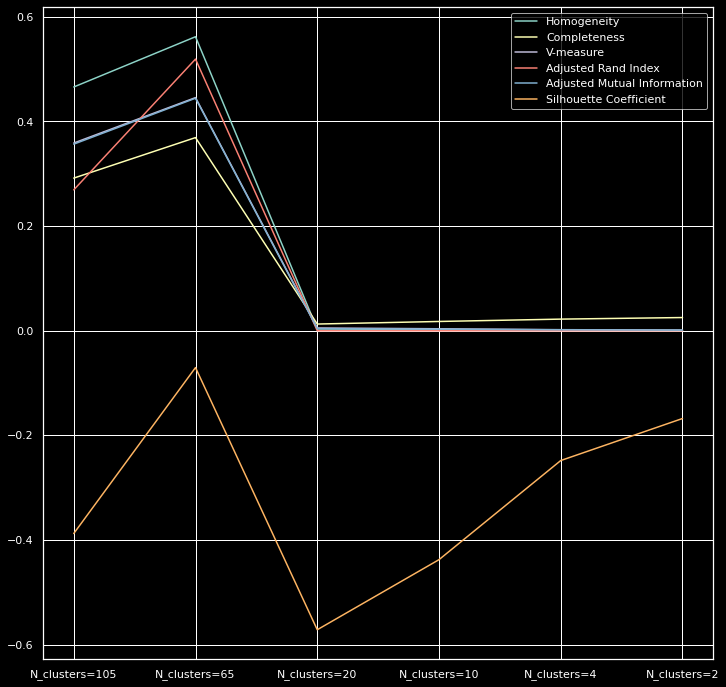

In [49]:
plt.style.use('dark_background')
DBSCAN_stats_df.plot(figsize=(12,12));

## DBSCAN with TSNE

In [53]:
db_eps_1 = DBSCAN(eps=0.05, min_samples=10).fit(proj_TSNE)
db_eps_2 = DBSCAN(eps=0.1, min_samples=10).fit(proj_TSNE)
db_eps_3 = DBSCAN(eps=0.15, min_samples=10).fit(proj_TSNE)
db_eps_4 = DBSCAN(eps=0.2, min_samples=10).fit(proj_TSNE)
db_eps_5 = DBSCAN(eps=0.25, min_samples=10).fit(proj_TSNE)
db_eps_6 = DBSCAN(eps=0.3, min_samples=10).fit(proj_TSNE)

In [54]:
DBSCAN_stats_df = creat_DBSCAN_metrics_df([db_eps_1, 
                                           db_eps_2, 
                                           db_eps_3, 
                                           db_eps_4, 
                                           db_eps_5, 
                                           db_eps_6],
                                          target)

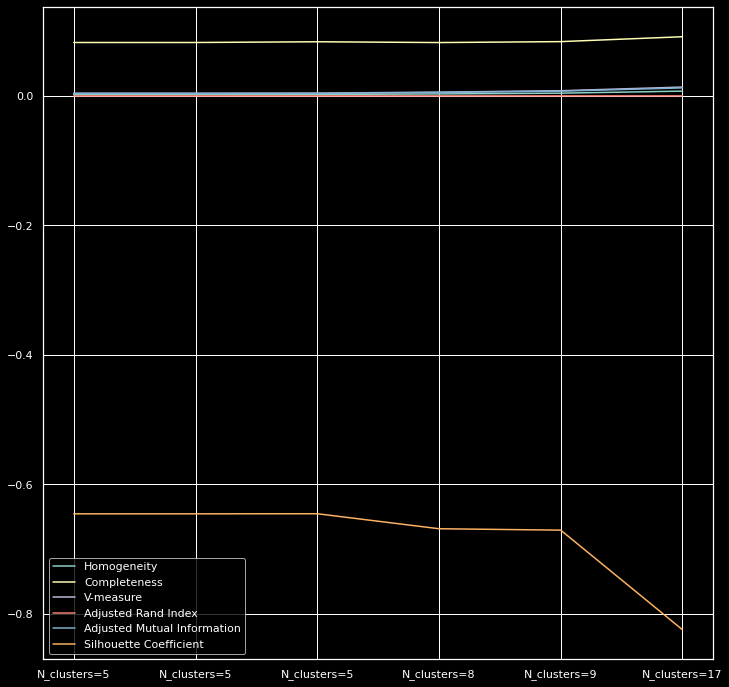

In [55]:
plt.style.use('dark_background')
DBSCAN_stats_df.plot(figsize=(12,12));

## KMeans with PCA

In [56]:
kmeans_3_PCA = KMeans(n_clusters=3, random_state=1234).fit(proj_PCA)
kmeans_4_PCA = KMeans(n_clusters=4, random_state=1234).fit(proj_PCA)
kmeans_5_PCA = KMeans(n_clusters=5, random_state=1234).fit(proj_PCA)
kmeans_6_PCA = KMeans(n_clusters=6, random_state=1234).fit(proj_PCA)
kmeans_7_PCA = KMeans(n_clusters=7, random_state=1234).fit(proj_PCA)
kmeans_8_PCA = KMeans(n_clusters=8, random_state=1234).fit(proj_PCA)

In [57]:
def creat_KMeans_metrics_df(models_list: list, 
                            target: list):
  """
  Creates KMeans dataframe with main clusters metrics
  :param models_list: list with models
  :param target: list with target labels
  :returns: pandas dataframe
  """

  metric_dict = {'Homogeneity': list(),
                'Completeness': list(),
                'V-measure': list(),
                'Adjusted Rand Index': list(),
                'Adjusted Mutual Information': list(),
                'Silhouette Coefficient': list()}

  for i, model in enumerate(models_list):
    labels = model.labels_
    metric_dict['Homogeneity'].append(metrics.homogeneity_score(target, labels))
    metric_dict['Completeness'].append(metrics.completeness_score(target, labels))
    metric_dict['V-measure'].append(metrics.v_measure_score(target, labels))
    metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(target, labels))
    metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(target, labels))
    metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

  stats_df = pd.DataFrame(metric_dict, index=['KMean'+str(i) for i in range(3, 9)])
  return stats_df 

KMeans_stats_df = creat_KMeans_metrics_df([kmeans_3_PCA, 
                                           kmeans_4_PCA, 
                                           kmeans_5_PCA, 
                                           kmeans_6_PCA, 
                                           kmeans_7_PCA, 
                                           kmeans_8_PCA],
                                           target)

### Visualize KMeans with PCA

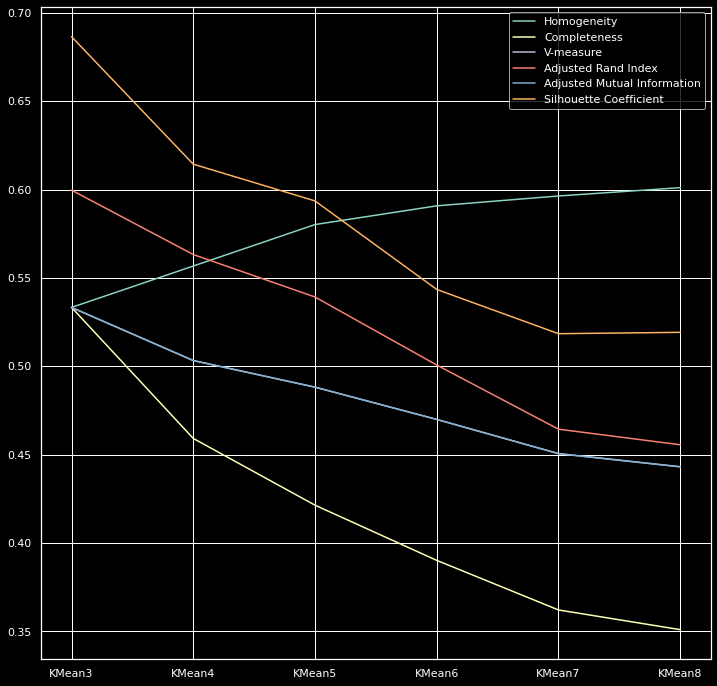

In [58]:
plt.style.use('dark_background')
KMeans_stats_df.plot(figsize=(12,12));

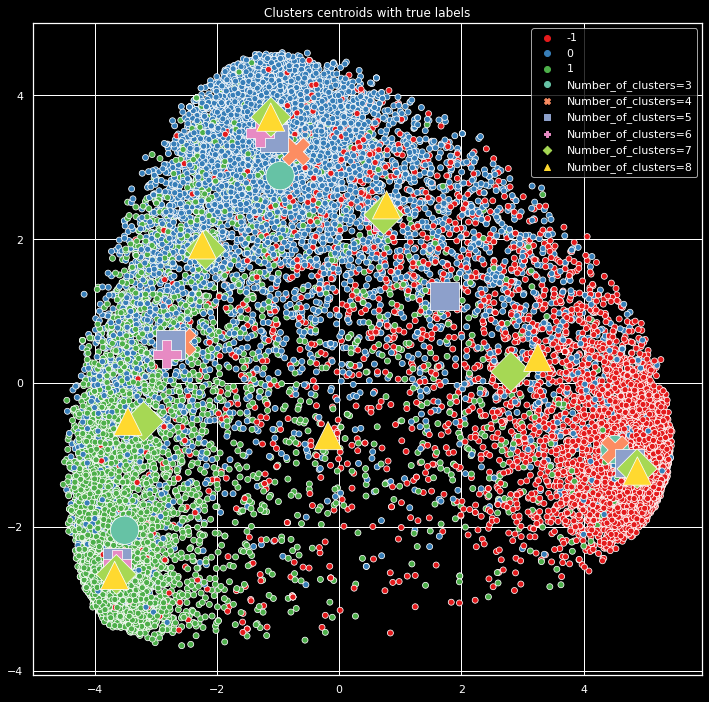

In [59]:
def visualize_clusters(x: np.array, 
                       y: np.array, 
                       cluster_num: int, 
                       models_list: list, 
                       hye: np.array):
  """
  visualizes clusters with less or equal number of centers
  :param x: array with x coordinates
  :param y: array with y coordinates
  :param cluster_num: int max number of clusters
  :param models_list: list with models
  :param hue: array labels
  :returns: plot
  """
  centers = list()
  center_quantity = list()
  for model in models_list[:cluster_num-2]:
    number_of_centers = len(model.cluster_centers_)
    centers.append(model.cluster_centers_)
    center_quantity += ["Number_of_clusters="+str(number_of_centers) for i in range(number_of_centers)]

  centers = np.concatenate(centers)

  plt.style.use('dark_background')
  ax = sns.scatterplot(x=x,
                       y=y, 
                       hue=hye, 
                       palette="Set1")
  ax = sns.scatterplot(x=centers[:, 0], 
                       y=centers[:, 1], 
                       hue=center_quantity, 
                       style=center_quantity, 
                       palette="Set2", 
                       s=800)
  sns.set(rc={'figure.figsize':(12, 12)})
  ax.set_title("Clusters centroids with true labels")

visualize_clusters(x=proj_PCA[:, 0],
                   y=proj_PCA[:, 1],
                   cluster_num=8,
                   models_list=[kmeans_3_PCA, 
                                kmeans_4_PCA, 
                                kmeans_5_PCA, 
                                kmeans_6_PCA, 
                                kmeans_7_PCA, 
                                kmeans_8_PCA],
                    hye=target)

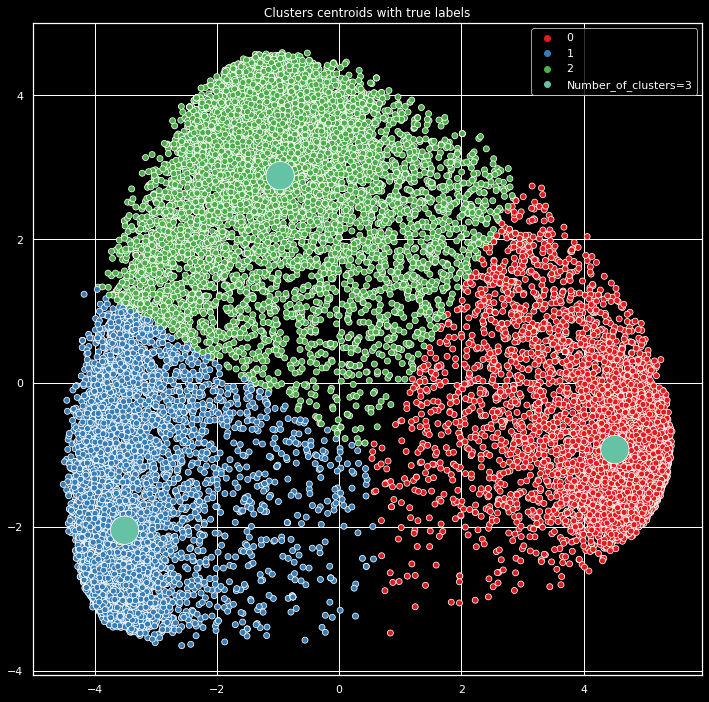

In [60]:
visualize_clusters(x=proj_PCA[:, 0],
                   y=proj_PCA[:, 1],
                   cluster_num=3,
                   models_list=[kmeans_3_PCA, 
                                kmeans_4_PCA, 
                                kmeans_5_PCA, 
                                kmeans_6_PCA, 
                                kmeans_7_PCA, 
                                kmeans_8_PCA],
                    hye=kmeans_3_PCA.labels_) 

## KMeans with TSNE

In [61]:
kmeans_3_TSNE = KMeans(n_clusters=3, random_state=1234).fit(proj_TSNE)
kmeans_4_TSNE = KMeans(n_clusters=4, random_state=1234).fit(proj_TSNE)
kmeans_5_TSNE = KMeans(n_clusters=5, random_state=1234).fit(proj_TSNE)
kmeans_6_TSNE = KMeans(n_clusters=6, random_state=1234).fit(proj_TSNE)
kmeans_7_TSNE = KMeans(n_clusters=7, random_state=1234).fit(proj_TSNE)
kmeans_8_TSNE = KMeans(n_clusters=8, random_state=1234).fit(proj_TSNE)

In [62]:
KMeans_stats_df = creat_KMeans_metrics_df([kmeans_3_TSNE, 
                                           kmeans_4_TSNE, 
                                           kmeans_5_TSNE, 
                                           kmeans_6_TSNE, 
                                           kmeans_7_TSNE, 
                                           kmeans_8_TSNE],
                                           target)

### Visualize KMeans with TSNE

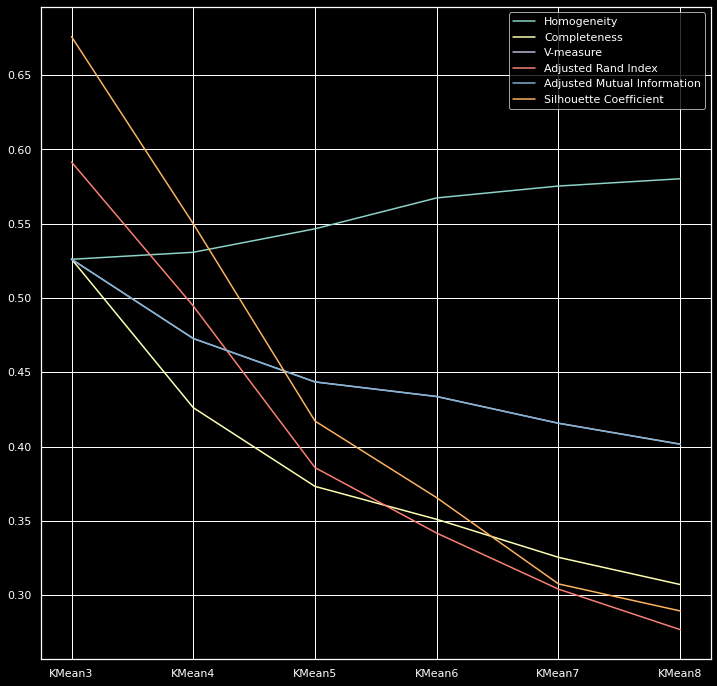

In [63]:
plt.style.use('dark_background')
KMeans_stats_df.plot(figsize=(12,12));

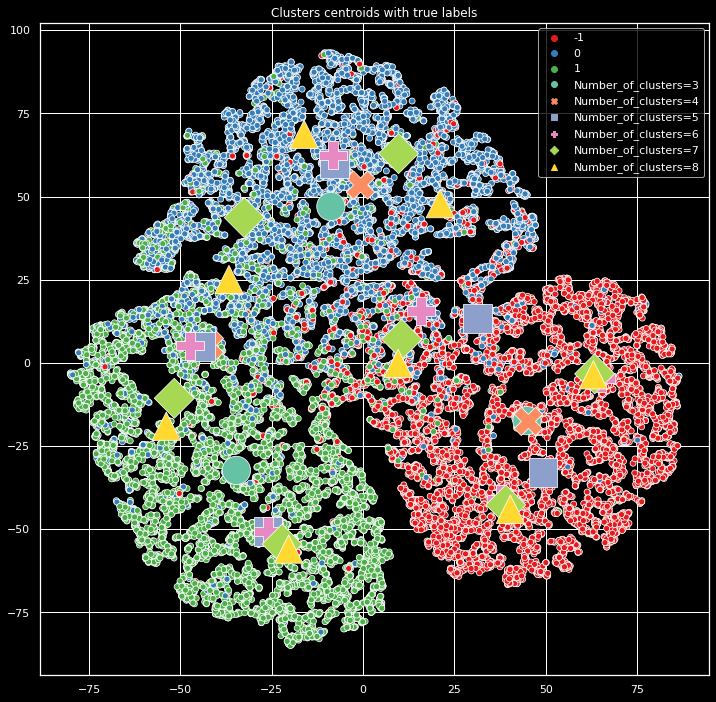

In [64]:
visualize_clusters(x=proj_TSNE[:, 0],
                   y=proj_TSNE[:, 1],
                   cluster_num=8,
                   models_list=[kmeans_3_TSNE, 
                                kmeans_4_TSNE, 
                                kmeans_5_TSNE, 
                                kmeans_6_TSNE, 
                                kmeans_7_TSNE, 
                                kmeans_8_TSNE],
                    hye=target)

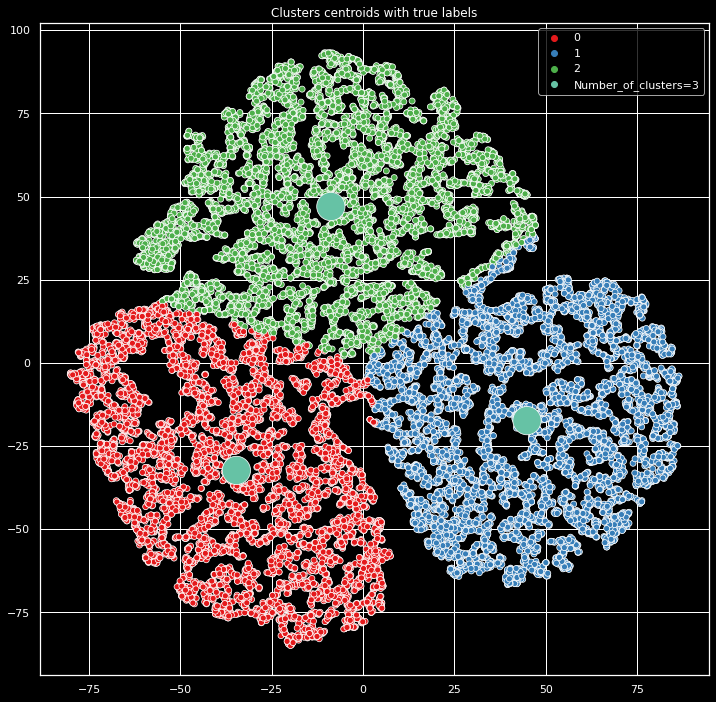

In [65]:
visualize_clusters(x=proj_TSNE[:, 0],
                   y=proj_TSNE[:, 1],
                   cluster_num=3,
                   models_list=[kmeans_3_TSNE, 
                                kmeans_4_TSNE, 
                                kmeans_5_TSNE, 
                                kmeans_6_TSNE, 
                                kmeans_7_TSNE, 
                                kmeans_8_TSNE],
                    hye=kmeans_3_TSNE.labels_) 

## Agglomerative Clustering with PCA

In [66]:
aglm_3_PCA = AgglomerativeClustering(n_clusters=3).fit(proj_PCA)
aglm_4_PCA = AgglomerativeClustering(n_clusters=4).fit(proj_PCA)
aglm_5_PCA = AgglomerativeClustering(n_clusters=5).fit(proj_PCA)
aglm_6_PCA = AgglomerativeClustering(n_clusters=6).fit(proj_PCA)
aglm_7_PCA = AgglomerativeClustering(n_clusters=7).fit(proj_PCA)
aglm_8_PCA = AgglomerativeClustering(n_clusters=8).fit(proj_PCA)

In [67]:
def creat_AGLM_metrics_df(models_list: list, 
                          target: list):
  """
  Creates Agglomerative Clustering dataframe with main clusters metrics
  :param models_list: list with models
  :param target: list with target labels
  :returns: pandas dataframe
  """

  metric_dict = {'Homogeneity': list(),
                'Completeness': list(),
                'V-measure': list(),
                'Adjusted Rand Index': list(),
                'Adjusted Mutual Information': list(),
                'Silhouette Coefficient': list()}

  for i, model in enumerate(models_list):
    labels = model.labels_
    metric_dict['Homogeneity'].append(metrics.homogeneity_score(target, labels))
    metric_dict['Completeness'].append(metrics.completeness_score(target, labels))
    metric_dict['V-measure'].append(metrics.v_measure_score(target, labels))
    metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(target, labels))
    metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(target, labels))
    metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

  stats_df = pd.DataFrame(metric_dict, index=['KMean'+str(i) for i in range(3, 9)])
  return stats_df 

AGLM_stats_df = creat_KMeans_metrics_df([aglm_3_PCA, 
                                           aglm_4_PCA, 
                                           aglm_5_PCA, 
                                           aglm_6_PCA, 
                                           aglm_7_PCA, 
                                           aglm_8_PCA],
                                           target)

### Visualize Agglomerative Clustering with PCA

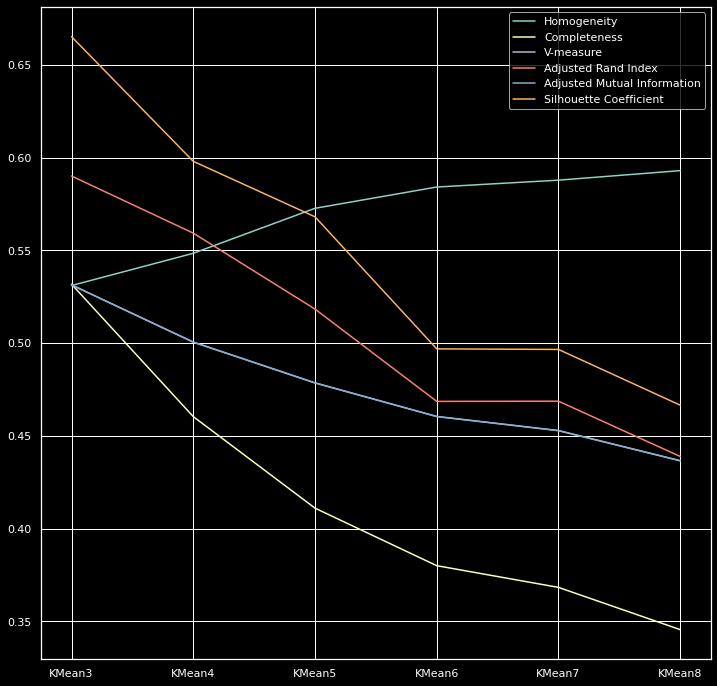

In [68]:
plt.style.use('dark_background')
AGLM_stats_df.plot(figsize=(12,12));

## Agglomerative Clustering with TSNE

In [69]:
aglm_3_TSNE = AgglomerativeClustering(n_clusters=3).fit(proj_TSNE)
aglm_4_TSNE = AgglomerativeClustering(n_clusters=4).fit(proj_TSNE)
aglm_5_TSNE = AgglomerativeClustering(n_clusters=5).fit(proj_TSNE)
aglm_6_TSNE = AgglomerativeClustering(n_clusters=6).fit(proj_TSNE)
aglm_7_TSNE = AgglomerativeClustering(n_clusters=7).fit(proj_TSNE)
aglm_8_TSNE = AgglomerativeClustering(n_clusters=8).fit(proj_TSNE)

In [70]:
AGLM_stats_df = creat_KMeans_metrics_df([aglm_3_PCA, 
                                           aglm_4_PCA, 
                                           aglm_5_PCA, 
                                           aglm_6_PCA, 
                                           aglm_7_PCA, 
                                           aglm_8_PCA],
                                           target)

### Visualize Agglomerative Clustering with TSNE

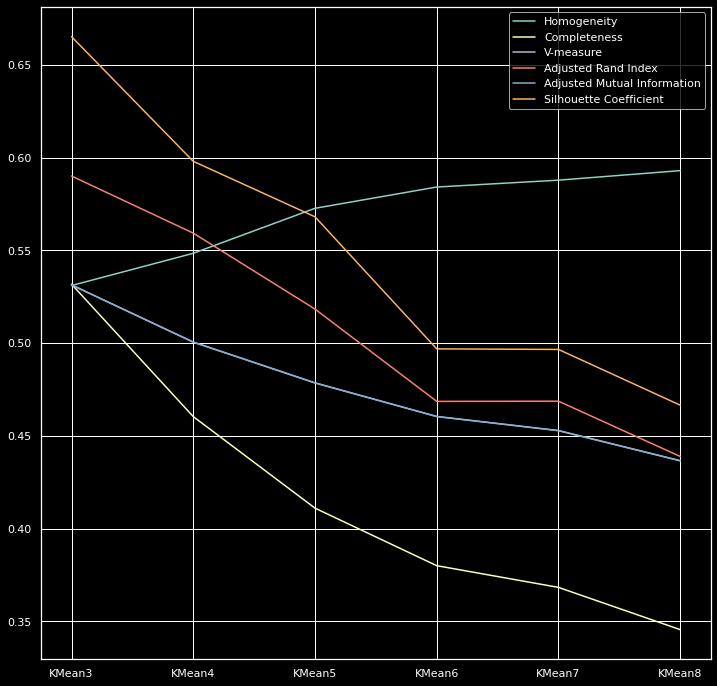

In [71]:
plt.style.use('dark_background')
AGLM_stats_df .plot(figsize=(12,12));

# Find wrong classified

In [102]:
#with random_stat = 1234 For kmeans_3_PCA: 
#cluster 0 = target -1
#cluster 1 = target 1 
#cluster 2 = target 0
PCA_cluster_to_target = {0:-1, 1: 1, 2: 0}
PCA_target_to_cluster = {-1:0, 1: 1, 0: 2}
#with random_stat = 1234 For kmeans_3_TSNE:  
#cluster 0 = target 1; 
#cluster 1 = target -1; 
#cluster 2 = target 0;
TSNE_cluster_to_target = {0: 1, 1: -1, 2: 0}
TSNE_cluster_to_target = {1: 0, -1: 1, 0: 2}

In [98]:
def convert_PCA_labels(model, 
                       cluster_to_target_dict):
  """
  Converts cluster numbers to target numbers
  :param model: clusterization model
  :return: array with targets
  """
  cluster_labels = model.labels_.copy()
  cluster_labels[cluster_labels==0] = cluster_to_target_dict[0]
  cluster_labels[cluster_labels==1] = cluster_to_target_dict[1]
  cluster_labels[cluster_labels==2] = cluster_to_target_dict[2]
  return cluster_labels

def convert_TSNE_labels(model, 
                        cluster_to_target_dict):
  """
  Converts cluster numbers to target numbers
  :param model: clusterization model
  :return: array with targets
  """
  cluster_labels = model.labels_.copy()
  cluster_labels[cluster_labels==1] = cluster_to_target_dict[1]
  cluster_labels[cluster_labels==0] = cluster_to_target_dict[0]
  cluster_labels[cluster_labels==2] = cluster_to_target_dict[2]
  return cluster_labels

PCA_cluster_labels = convert_PCA_labels(kmeans_3_PCA,
                                        PCA_cluster_to_target)
TSNE_cluster_labels = convert_TSNE_labels(kmeans_3_TSNE,
                                          TSNE_cluster_to_target)

In [99]:
# cluster labels and target labels overlay
sum(PCA_cluster_labels == target) ,sum(TSNE_cluster_labels == target)

(19699, 19625)

# Now we are using only PCA with 3 clusters KMeans

## Visualize overlay

In [108]:
def make_overlay_hye(cluster_lebels: np.array, 
                     target_labels: np.array):
  """
  Creates an array with overlay "status"
  :param cluster_lebels: array with cluster labels
  :param target_lebels: array with taget labels
  :returns: hye list with status for visualization
  """
  hye_list = list()
  layer_overlay = target_labels - cluster_lebels

  for i in range(len(layer_overlay)):
    if layer_overlay[i] == 0: hye_list += ["Labels classified similarly"]
    elif layer_overlay[i] == -2: hye_list += ["Target -1 classified as 1"]
    elif layer_overlay[i] == 2: hye_list += ["Target 1 classified as -1"]       
    elif layer_overlay[i] == -1 and target_labels[i] ==-1: hye_list += ["Target -1 classified as 0"]
    elif layer_overlay[i] == -1 and target_labels[i] == 0: hye_list += ["Target 0 classified as 1"]
    elif layer_overlay[i] == 1 and target_labels[i] == 1: hye_list += ["Target 1 classified as 0"]
    elif layer_overlay[i] == 1 and target_labels[i] == 0: hye_list += ["Target 0 classified as -1"]

  return hye_list

layer_overlay = make_overlay_hye(PCA_cluster_labels, 
                                 target)

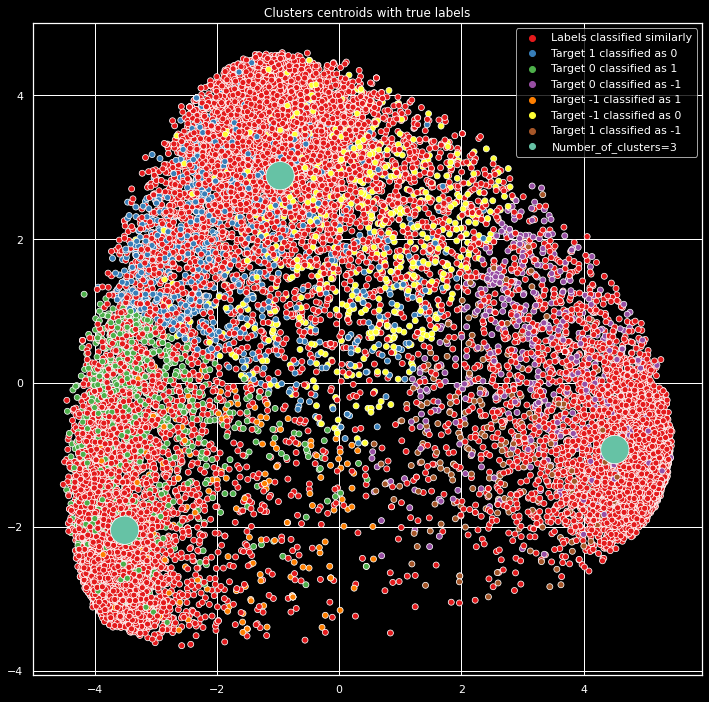

In [111]:
visualize_clusters(x=proj_PCA[:, 0],
                   y=proj_PCA[:, 1],
                   cluster_num=3,
                   models_list=[kmeans_3_PCA],
                    hye=layer_overlay)

## Find distance

In [136]:
def find_true_centers(cluster_centers: np.array, 
                      target: np.array, 
                      target_to_cluster_dict: dict):
  """
  For target values calculate cluster center coordinates
  :param cluster_centers: array with cluster centers
  :param target: array with targets
  :param target_to_cluster_dict: dict where keys are target and values are cluster numbers
  :returns: array with cluster centers coordinates
  """
  center_coordinates = list()
  for i in range(len(target)):
    cluster_number = target_to_cluster_dict[target[i]]
    center_coordinates.append(cluster_centers[cluster_number])

  center_coordinates = np.vstack(center_coordinates)
  return center_coordinates

cluster_centers = find_true_centers(kmeans_3_PCA.cluster_centers_,
                                    target,
                                    PCA_target_to_cluster)
#calculate vectors to cluster centers
vectors_to_centers = proj_PCA - cluster_centers
#calculate distance to cluster centers
distance_to_centers = np.linalg.norm(vectors_to_centers, axis=1)
#calculate distance is sigma to cluster centers
distance_in_sigma = distance_to_centers/distance_to_centers.std()

## Visualize distance

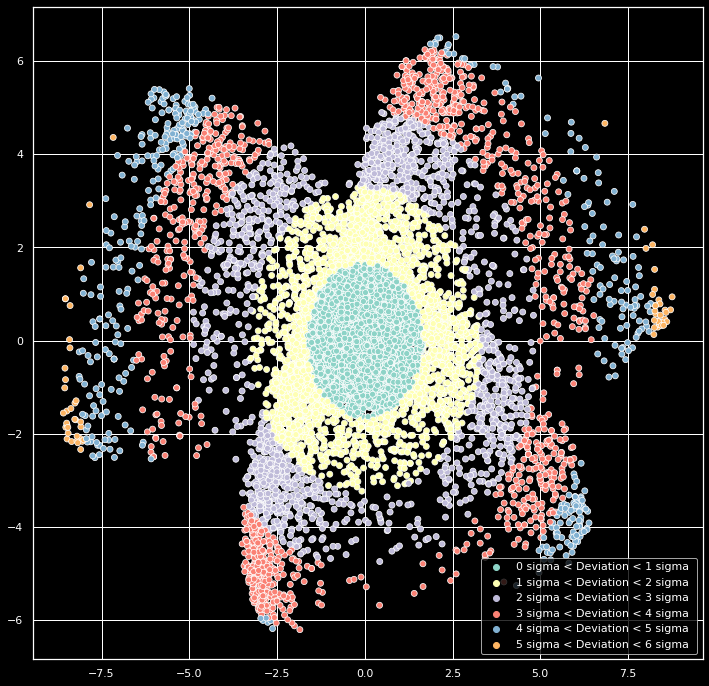

In [267]:
def make_hye(distance_to_centers: np.array):
  """
  Creates annotation for plot
  :param distance_to_centers: distance to center (Frobenius norm)
  :param std_deviation_n: number of standard deviations
  :returns: list with annotation
  """
  hye = list()
  sigma = distance_to_centers.std()
  distance_in_sigma = (distance_to_centers//sigma).astype(int)
  max_dev = int(max(distance_in_sigma))
  sigma_annotations = [f'{num} sigma < Deviation < {num+1} sigma ' for num in range(max_dev+1)]
  
  for i in range(len(distance_in_sigma)):
    hye.append(sigma_annotations[distance_in_sigma[i]])

  return hye

hye = make_hye(distance_to_centers)

plt.style.use('dark_background')

sns.scatterplot(x=vectors_to_centers[:, 0],
                y=vectors_to_centers[:, 1],
                hue=hye);

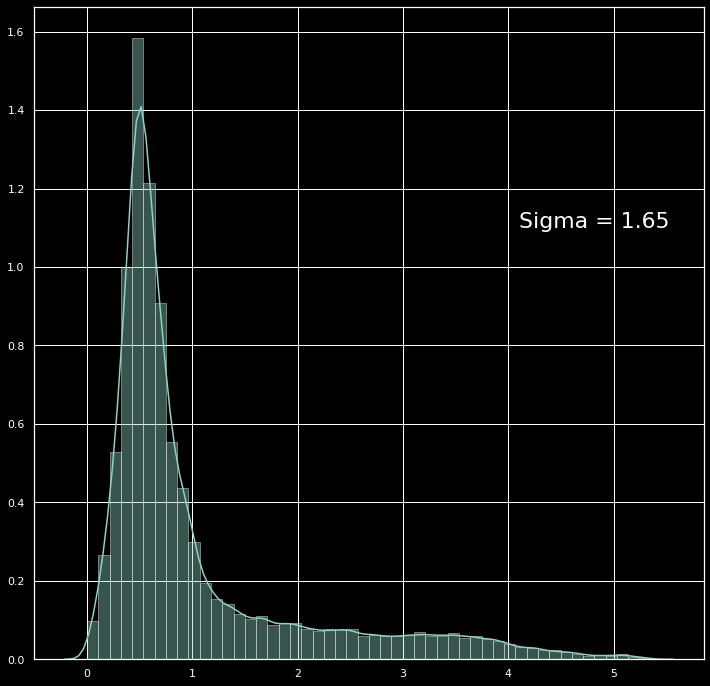

In [230]:
sns.distplot(distance_in_sigma);
plt.text(4.1, 1.1, 'Sigma = {:.2f}'.format(distance_to_centers.std()), fontsize=22);

# View data

In [245]:
condition = ['ENT' in text for text in train_df.text]
train_df = train_df[condition]

In [263]:
for text in train_df[distance_in_sigma>3].head(10).text:
  print(text)
print(train_df[distance_in_sigma>3].head(10).label)

Петроглиф автоматизация бизнеса О последствиях антилояльности Антилояльность или низкая лояльность покупателей к брендам производителей и торговым сетям – причины и возможные последствия Говоря о внедрениях программ лояльности очень многие считают что работа с различными скидками бонусами и механиками промо – это и есть программы лояльности Причем речь идет как о программах лояльности торговых сетей так и программах лояльности отдельных поставщиков Однако это мнение ошибочно и выдача пластиковой карты покупателю по которой он может получить скидку это еще не программа лояльности и непонимание этого уже приводит к весьма неприятным последствиям Давайте посмотрим на недавнее исследование Nielsen где утверждается что « только 12 российских потребителей остаются верны выбранному бренду тогда как остальные 88 регулярно переключаются между конкурирующими товарами И сегодня это происходит в полтора раза чаще чем пять лет назад » Причем в большинстве базовых категорий таких как бакалея хлеб и 

In [265]:
sum(distance_in_sigma>2.5)

2597

In [266]:
train_df[distance_in_sigma>2.5].to_csv('/content/drive/My Drive/outliers_review.csv')